## B cells versus T cells
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we note presence/absense changes and quantify fold changes using a T test.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load()
#data_raw.head()

In [2]:
def check_present(row):
    bool_row = []
    for i in row:
        bool_row.append(bool(i))
    return sum(bool_row)

def check_three_of_each_type(row, cell_types=["B_cell", "T_cell"]):
    present_in_types = []
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        data_by_type = row.loc[cells_of_type]
        in_type = check_present(data_by_type)
        three_in_type = bool(in_type > 2)
        present_in_types.append(three_in_type)
    if sum(present_in_types) == len(cell_types):
        return True
    else: return False
    
def check_presence_absence(row, cell_types=["B_cell", "T_cell"], min_reps=3):
    present_in_types = {}
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        data_by_type = row.loc[cells_of_type]
        in_type = check_present(data_by_type)
        present_in_types[i] = in_type
    if 0 in list(present_in_types.values()):#absent in one type
        if present_in_types[cell_types[0]] >= min_reps:
            return 1
        elif present_in_types[cell_types[1]]>= min_reps:
            return 2

Here, we record which proteins are only identified in one cell type.

In [3]:
present_only_in = data_raw.apply(check_presence_absence, axis=1).dropna()
present_only_in = data_raw.loc[present_only_in.index]
len(present_only_in)

77

Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [4]:
indecies = data_raw.apply(check_three_of_each_type, axis=1)
data = data_raw[indecies]

Now we normalize across runs.

Finally, we will calculate the coeffients of variation for each protein within each of the two cell types. 

In [5]:
from scipy.stats import ttest_ind
from statistics import mean
import pandas as pd

In [6]:
def ttest_wrapper(row, cell_types = ["B_cell", "T_cell"]):
    split_row = []
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        split_row.append(row.loc[cells_of_type])
        
    tstat = ttest_ind(split_row[0],split_row[1])
    tstat = pd.Series(dict(statistic=tstat[0], pvalue=tstat[1]))
    return tstat
    
#Call ttest function
tstats = data.apply(ttest_wrapper, axis=1)

In [7]:
#calculate fold_changes
from numpy import log2
def get_fold_changes(row, cell_types=["B_cell", "T_cell"]):
    means = {}
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        data_by_type = row.loc[cells_of_type]
        means[i] = mean(data_by_type)
    return (means[cell_types[0]]/means[cell_types[1]])
        
tstats['fold_change'] = data.apply(get_fold_changes, axis=1)
tstats['log2 Fold Change'] = log2(tstats['fold_change'])

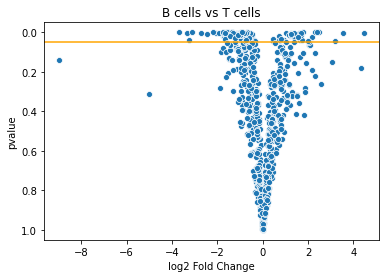

In [8]:
#graph volcano
import matplotlib.pyplot as plt
import seaborn as sns

figure = sns.scatterplot(x='log2 Fold Change',y='pvalue',data=tstats)
figure.set_title("B cells vs T cells")
#plt.axvline(1, color ='orange')
#plt.axvline(-1, color ='orange')
plt.axhline(.05, color ='orange')
figure.invert_yaxis()


In [9]:
#get higher-in-B and higher-in-T proteins
def is_altered(tscore, pvalue=.05,change_factor=2):
    log2_fold_change=log2(change_factor)
    if tscore['pvalue'] < pvalue:
        if tscore['log2 Fold Change'] > log2_fold_change:
            #first type is statistically bigger
            return 'B cells'
        elif tscore['log2 Fold Change'] < -log2_fold_change:
            #second type is statistically bigger
            return "T cells"
        
altered = tstats.apply(is_altered, axis=1).dropna()

In [10]:
altered.value_counts()

T cells    43
B cells    28
dtype: int64

In [11]:
print("P<0.05, 50% increase")
print(tstats.apply(is_altered, axis=1, pvalue=.05,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.05, 200% increase")
print(tstats.apply(is_altered, axis=1, pvalue=.05,change_factor=2).value_counts()) #200% increase from either
print("\nP<0.05, 500% increase")
print(tstats.apply(is_altered, axis=1, pvalue=.05,change_factor=5).value_counts()) #500% increase from either

print("\nP<0.01, 50% increase")
print(tstats.apply(is_altered, axis=1, pvalue=.01,change_factor=1.5).value_counts()) #50% increase from either
print("\nP<0.01, 200% increase")
print(tstats.apply(is_altered, axis=1, pvalue=.01,change_factor=2).value_counts()) #200% increase from either
print("\nP<0.01, 500% increase")
print(tstats.apply(is_altered, axis=1, pvalue=.01,change_factor=5).value_counts()) #500% increase from either

P<0.05, 50% increase
T cells    74
B cells    33
dtype: int64

P<0.05, 200% increase
T cells    43
B cells    28
dtype: int64

P<0.05, 500% increase
T cells    6
B cells    5
dtype: int64

P<0.01, 50% increase
T cells    37
B cells    13
dtype: int64

P<0.01, 200% increase
T cells    27
B cells    13
dtype: int64

P<0.01, 500% increase
T cells    5
B cells    4
dtype: int64


In [12]:
#tstats.loc[altered.index].sort_values('fold_change')

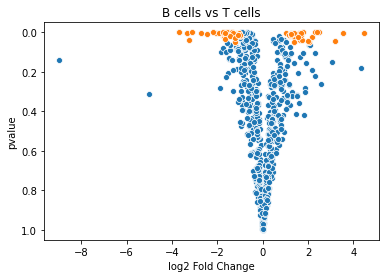

In [13]:
figure = sns.scatterplot(x='log2 Fold Change',y='pvalue',data=tstats)
figure2 = sns.scatterplot(x='log2 Fold Change',y='pvalue',data=tstats.loc[altered.index])
plt.title("B cells vs T cells")
figure.invert_yaxis()

This shows...
